# Chapter 5

## Initial Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# More or less two minutes to install these packages.
# !pip install tensorflow tqdm

In [3]:
%%time

# Load packages.
import os
import sys
import time
import torch
import psutil
import tiktoken

import urllib.request

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator

torch.set_printoptions(sci_mode=False)

CPU times: user 2.27 s, sys: 400 ms, total: 2.67 s
Wall time: 2.63 s


In [4]:
ancillar_path = "/llm_app/notebooks/build_large_language_models_from_scratch/"
if ancillar_path not in sys.path:
    sys.path.append(ancillar_path)

import ancillar as aux

In [5]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,  # Vocabulary size.
    "context_length": 256,  # Shortened context length (orig: 1024).
    "emb_dim": 768,  # Embedding dimension.
    "n_heads": 12,  # Number of attention heads.
    "n_layers": 12,  # Number of layers.
    "drop_rate": 0.1,  # Dropout rate.
    "qkv_bias": False,  # Query-key-value bias.
}

torch.manual_seed(123);

## Evaluating Generative Text Models

### Using GPT to Generate Text

In [6]:
model = aux.GPTModel(GPT_CONFIG_124M)

# Disable dropout during inference.
model.eval();

In [7]:
# Listing 5.1: Utility functions for text to token ID conversion.
def text_to_token_ids(text, tokenizer):

    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

    # Add batch dimension.
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)

    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):

    # Remove batch dimension.
    flat = token_ids.squeeze(0)

    return tokenizer.decode(flat.tolist())

In [8]:
%%time

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = aux.generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"],
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren
CPU times: user 2.35 s, sys: 24 ms, total: 2.38 s
Wall time: 873 ms


### Calculating the Text Generation Loss

In [9]:
inputs = torch.tensor(
    [[16833, 3626, 6100], [40, 1107, 588]]  # ["every effort moves",
)  #  "I really like"]

targets = torch.tensor(
    [[3626, 6100, 345], [1107, 588, 11311]]  # [" effort moves you",
)  #  " really like chocolate"]

In [10]:
# Disables gradient tracking since we are not training yet.
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1)  # Probability of each token in vocabulary
print(probas.shape)  # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


In [11]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)

print(f">>> `token_ids` shape:\n{token_ids.shape}\n")
print(f">>> Token IDs:\n{token_ids}")

>>> `token_ids` shape:
torch.Size([2, 3, 1])

>>> Token IDs:
tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [12]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [13]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([    0.0001,     0.0000,     0.0000])
Text 2: tensor([    0.0000,     0.0001,     0.0000])


In [14]:
# Compute logarithm of all token probabilities.
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))

print(f">>> Logarithm of token probabilities:\n{log_probas}")

>>> Logarithm of token probabilities:
tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [15]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)

print(f">>> Average log probability:\n{avg_log_probas}")

>>> Average log probability:
-10.79397201538086


In [16]:
neg_avg_log_probas = avg_log_probas * -1

print(f">>> Negative average log probability:\n{neg_avg_log_probas}")

>>> Negative average log probability:
10.79397201538086


In [17]:
print(">>> Logits shape:", logits.shape)
print(">>> Targets shape:", targets.shape)

>>> Logits shape: torch.Size([2, 3, 50257])
>>> Targets shape: torch.Size([2, 3])


In [18]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print(">>> Flattened logits:", logits_flat.shape)
print(">>> Flattened targets:", targets_flat.shape)

>>> Flattened logits: torch.Size([6, 50257])
>>> Flattened targets: torch.Size([6])


In [19]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)

print(loss)

tensor(10.7940)


In [20]:
perplexity = torch.exp(loss)

print(perplexity)

tensor(48726.1953)


### Calculating the Training and Validation Set Losses

In [21]:
file_path = (
    "/llm_app/notebooks/build_large_language_models_from_scratch/the-verdict.txt"
)
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):

    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode("utf-8")
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [22]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [23]:
# Train / validation ratio.
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))

train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

print(">>> Length of training data:", len(train_data))
print(">>> Length of validation data:", len(val_data))

>>> Length of training data: 18431
>>> Length of validation data: 2048


In [24]:
torch.manual_seed(123)

train_loader = aux.create_dataloader_v1(
    txt=train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0,
)

val_loader = aux.create_dataloader_v1(
    txt=val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0,
)

In [25]:
print(">>> Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\n>>> Validation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

>>> Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

>>> Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [26]:
def calc_loss_batch(input_batch, target_batch, model, device):

    # The transfer to a given device allows us to transfer the data to a GPU.
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )

    return loss

In [27]:
def calc_loss_loader(data_loader, model, device, num_batches=None):

    total_loss = 0.0

    if len(data_loader) == 0:
        return float("nan")

    # Iteratives over all batches if no fixed num_batches is specified.
    elif num_batches is None:
        num_batches = len(data_loader)

    # Reduce the number of batches to match the total number of batches in the data loader
    # if num_batches exceeds the number of batches in the data loader.
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break

    return total_loss / num_batches

In [28]:
%%time

# If you have a machine with a CUDA-supported GPU, the LLM will train on the GPU without making any changes to the code.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(">>> Device:", device)
model.to(device)

# For reproducibility due to the shuffling in the data loader.
torch.manual_seed(123)

# Disable gradient tracking for efficiency because we are not training, yet.
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print(">>> Training loss:", train_loss)
print(">>> Validation loss:", val_loss)

>>> Device: cpu


>>> Training loss: 10.987582206726074
>>> Validation loss: 10.98110580444336
CPU times: user 14.8 s, sys: 4.75 s, total: 19.5 s
Wall time: 4.93 s


## Training an LLM

In [29]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    """
    Prints the training and validation set losses after each model update so we can evaluate whether the training improves the model.
    """

    # Dropout is disabled during evaluation for stable, reproducible results.
    model.eval()

    # Disables gradient tracking, which is not required during evaluation, to reduce the computational overhead.
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)

    model.train()

    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    """
    Provides a concrete text example generated by the model to judge its capabilities during training.
    """

    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)

    with torch.no_grad():

        token_ids = aux.generate_text_simple(
            model=model, idx=encoded, max_new_tokens=50, context_size=context_size
        )

    decoded_text = token_ids_to_text(token_ids, tokenizer)

    # Compact print format.
    print(decoded_text.replace("\n", " "))
    model.train()

In [30]:
def train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    eval_iter,
    start_context,
    tokenizer,
):
    """
    # Listing 5.3: The main function for pretraining LLMs.
    """

    # Initialize lists to track losses and tokens seen.
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop.
    for epoch in range(num_epochs):

        # Set model to training mode.
        model.train()

        # Iterate over all batches in the training data.
        for input_batch, target_batch in train_loader:

            # Reset loss gradients from previous batch iteration.
            optimizer.zero_grad()

            # Calculate loss.
            loss = calc_loss_batch(input_batch, target_batch, model, device)

            #  Calculate loss gradients.
            loss.backward()

            # Update model weights using loss gradients.
            optimizer.step()

            # Track the number of tokens seen and global step.
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step.
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                print(
                    f">>> Epoch: {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, Validation loss {val_loss:.3f}"
                )

        # Print a sample text after each epoch.
        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen

In [31]:
%%time

torch.manual_seed(123)

start_time = time.time()

model = aux.GPTModel(GPT_CONFIG_124M)
model.to(device)

# The .parameters() method returns all trainable weight parameters of the model.
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f">>> Training completed in {execution_time_minutes:.2f} minutes.")

>>> Epoch: 1 (Step 000000): Train loss 9.783, Validation loss 9.927
>>> Epoch: 1 (Step 000005): Train loss 7.985, Validation loss 8.335
Every effort moves you,,,,,,,,,,,,.                                     
>>> Epoch: 2 (Step 000010): Train loss 6.753, Validation loss 7.048
>>> Epoch: 2 (Step 000015): Train loss 6.114, Validation loss 6.573
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,,,,, and,,,, and,, and,,,,, and,,,,,,
>>> Epoch: 3 (Step 000020): Train loss 5.525, Validation loss 6.490
>>> Epoch: 3 (Step 000025): Train loss 5.324, Validation loss 6.388
Every effort moves you, and to the picture.                      "I, and the of the of the's the honour, and, and I had been, and I
>>> Epoch: 4 (Step 000030): Train loss 4.762, Validation loss 6.360
>>> Epoch: 4 (Step 000035): Train loss 4.461, Validation loss 6.257
Every effort moves you of the to the picture--as of the picture--as I had been " it was his " I was the     "I was his I had been the his pictures--and

In [32]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(8, 4))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    # Only show integer labels on x-axis.
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Create a second x-axis for tokens seen.
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis.
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks.
    ax2.set_xlabel("Tokens seen")

    # Adjust layout to make room.
    fig.tight_layout()
    plt.savefig("loss-plot.pdf")
    plt.show()

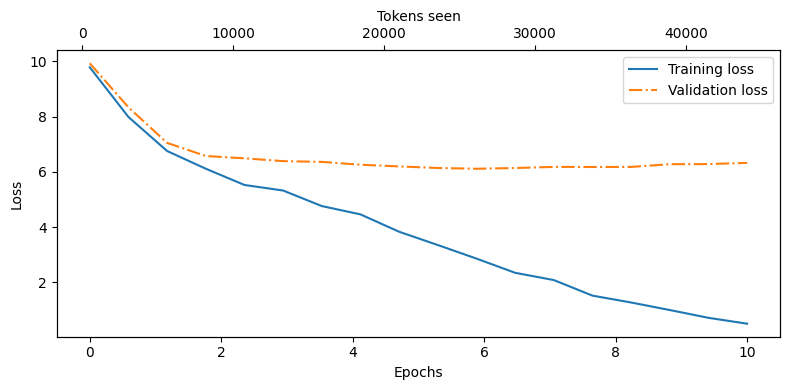

In [33]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## Decoding Strategies to Control Randomness

In [34]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [35]:
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = aux.generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"],
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




### Temperature Scaling

In [36]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

In [37]:
# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

forward


In [38]:
100 * probas

tensor([    6.0907,     0.1631,     0.0100,    57.2120,     0.3419,     0.0133,
            0.0101,    35.7576,     0.4012])

In [39]:
torch.manual_seed(123)

next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [40]:
def print_sampled_tokens(probas):

    torch.manual_seed(123)  # Manual seed for reproducibility.
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")


print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


In [41]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature

    return torch.softmax(scaled_logits, dim=0)

In [42]:
# Temperature values.
# Original, higher confidence, and lower confidence.
temperatures = [1, 0.1, 5]

# Calculate scaled probabilities.
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

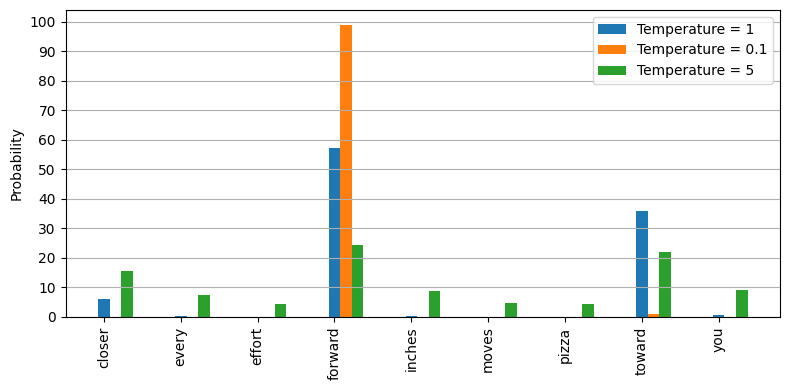

In [43]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(8, 4))
for i, T in enumerate(temperatures):
    rects = ax.bar(
        x + i * bar_width, 100 * scaled_probas[i], bar_width, label=f"Temperature = {T}"
    )

ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
ax.set_yticks(100 * np.arange(0.0, 1.1, 0.1))
ax.grid(axis="y")

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

#### Exercise 5.1

In [44]:
print_sampled_tokens(scaled_probas[0])

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


In [45]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
992 x forward
0 x inches
0 x moves
0 x pizza
8 x toward


In [46]:
print_sampled_tokens(scaled_probas[2])

153 x closer
68 x every
55 x effort
223 x forward
102 x inches
50 x moves
43 x pizza
218 x toward
88 x you


In [47]:
temp5_idx = 2
pizza_idx = 6

scaled_probas[temp5_idx][pizza_idx]

tensor(0.0430)

## Top-k Sampling

In [48]:
print(f">>> RAM usage: {psutil.virtual_memory().percent:.2f}%")

>>> RAM usage: 25.40%


In [49]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print(">>> Top logits:", top_logits)
print(">>> Top positions:", top_pos)

>>> Top logits: tensor([6.7500, 6.2800, 4.5100])
>>> Top positions: tensor([3, 7, 0])


In [50]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits,
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [51]:
next_token_logits

tensor([ 4.5100,  0.8900, -1.9000,  6.7500,  1.6300, -1.6200, -1.8900,  6.2800,
         1.7900])

In [52]:
new_logits

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])

In [53]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


## Modifying the Text Generation Function

In [54]:
def generate(
    model,
    idx,
    max_new_tokens,
    context_size,
    temperature=0.0,
    top_k=None,
    eos_id=None,
    verbose=False,
):
    """
    Listing 5.4 A modified text generation function with more diversity.
    """

    if verbose:
        print(f">>> IDX: {idx}; shape: {idx.shape}")

    # For-loop is the same as before: Get logits, and only focus on last time step.
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)

            if verbose:
                print(f">>> LOGITS shape: {logits.shape}")

        # Last time step logits (batch_size, context_len, vocab_size) -> (batch_size, vocab_size).
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling.
        if top_k is not None:
            # Keep only top_k values.
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                condition=logits < min_val,
                input=torch.tensor(float("-inf")).to(logits.device),
                other=logits,
            )

        # New: Apply temperature scaling.
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities.
            probs = torch.softmax(logits, dim=-1)  # (batch_size, vocab_size)

            # Sample from the distribution.
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value.
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        # Stop generating early if end-of-sequence token is encountered and eos_id is specified.
        if idx_next == eos_id:
            break

        # Same as before: append sampled index to the running sequence.
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens + 1)

    return idx

In [55]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4,
)

print(">>> Output text:\n", token_ids_to_text(token_ids, tokenizer))

>>> Output text:
 Every effort moves you know began to my surprise, a little it was the
"Ah enough


### Exercise 5.2 

In [56]:
%%time

# Number of experiments to run for different top_k values.
n_experiments = 5

# Different top_k values to test.
top_ks = [3, 25, 75, 250]
temperature = 1.4

for top_k in top_ks:
    for n_experiment in range(n_experiments):
        print(
            f"\n>>> Experiment {n_experiment + 1}/{n_experiments} with Topk={top_k} and Temperature={temperature} ..."
        )

        # Generate text with the specified top_k.
        token_ids = generate(
            model=model,
            idx=text_to_token_ids("Every effort moves you", tokenizer),
            max_new_tokens=15,
            context_size=GPT_CONFIG_124M["context_length"],
            top_k=top_k,
            temperature=temperature,
        )

        # Print the generated text.
        print(f"{token_ids_to_text(token_ids, tokenizer)}")


>>> Experiment 1/5 with Topk=3 and Temperature=1.4 ...
Every effort moves you?"

"Yes--quite insensible to the fact with the last

>>> Experiment 2/5 with Topk=3 and Temperature=1.4 ...
Every effort moves you?"

"Yes--I glanced after him the irony. She wanted

>>> Experiment 3/5 with Topk=3 and Temperature=1.4 ...
Every effort moves you say to put it all the axioms he laid down across the background

>>> Experiment 4/5 with Topk=3 and Temperature=1.4 ...
Every effort moves you?"

"Yes--quite insensible to the irony. She wanted

>>> Experiment 5/5 with Topk=3 and Temperature=1.4 ...


Every effort moves you?"

"
I felt able to the the irony. She wanted

>>> Experiment 1/5 with Topk=25 and Temperature=1.4 ...
Every effort moves you sunbur inevitable not till my hostess was "-- seen a tips of

>>> Experiment 2/5 with Topk=25 and Temperature=1.4 ...
Every effort moves you in the inevitable garlanded of my dear felt nervous so told me in

>>> Experiment 3/5 with Topk=25 and Temperature=1.4 ...
Every effort moves you ever

"Yes--quite. Gisburn--as such--

>>> Experiment 4/5 with Topk=25 and Temperature=1.4 ...
Every effort moves you?"

Of and my hostess answered with a dep or to the

>>> Experiment 5/5 with Topk=25 and Temperature=1.4 ...
Every effort moves you know with random up-chairs wild--I moved, at the equanim

>>> Experiment 1/5 with Topk=75 and Temperature=1.4 ...
Every effort moves you thought Jack Gisburn rather a cheap'ty't--as; not

>>> Experiment 2/5 with Topk=75 and Temperature=1.4 ...
Every effort moves you frame?"
For the marble her were, and't seen a pi

In [57]:
%%time

# Number of experiments to run for different top_k values.
n_experiments = 5

# Different top_k values to test.
top_k = 5
temperatures = [0.0, 0.1, 0.3, 1.0, 3.0, 10]

for temperature in temperatures:
    for n_experiment in range(n_experiments):
        print(
            f"\n>>> Experiment {n_experiment + 1}/{n_experiments} with Topk={top_k} and Temperature={temperature} ..."
        )

        # Generate text with the specified top_k.
        token_ids = generate(
            model=model,
            idx=text_to_token_ids("Every effort moves you", tokenizer),
            max_new_tokens=15,
            context_size=GPT_CONFIG_124M["context_length"],
            top_k=top_k,
            temperature=temperature,
        )

        # Print the generated text.
        print(f"{token_ids_to_text(token_ids, tokenizer)}")


>>> Experiment 1/5 with Topk=5 and Temperature=0.0 ...
Every effort moves you?"

"Yes--quite insensible to the irony. She wanted

>>> Experiment 2/5 with Topk=5 and Temperature=0.0 ...


Every effort moves you?"

"Yes--quite insensible to the irony. She wanted

>>> Experiment 3/5 with Topk=5 and Temperature=0.0 ...
Every effort moves you?"

"Yes--quite insensible to the irony. She wanted

>>> Experiment 4/5 with Topk=5 and Temperature=0.0 ...
Every effort moves you?"

"Yes--quite insensible to the irony. She wanted

>>> Experiment 5/5 with Topk=5 and Temperature=0.0 ...
Every effort moves you?"

"Yes--quite insensible to the irony. She wanted

>>> Experiment 1/5 with Topk=5 and Temperature=0.1 ...
Every effort moves you?"

"Yes--quite insensible to the irony. She wanted

>>> Experiment 2/5 with Topk=5 and Temperature=0.1 ...
Every effort moves you?"

"Yes--quite insensible to the irony. She wanted

>>> Experiment 3/5 with Topk=5 and Temperature=0.1 ...
Every effort moves you?"

"Yes--quite insensible to the irony. She wanted

>>> Experiment 4/5 with Topk=5 and Temperature=0.1 ...
Every effort moves you?"

"Yes--quite insensible to the irony. She wanted

>>> Experiment 

### Exercise 5.3

- Applying no temperature scaling;
- Applying `top_k=1`;

## Loading and Saving Model Weights in PyTorch

In [58]:
%%time

print(model)
torch.save(model.state_dict(), "/llm_app/models/model_chapter5.pth")

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

CPU times: user 349 ms, sys: 322 ms, total: 670 ms
Wall time: 5.97 s


In [59]:
model = aux.GPTModel(GPT_CONFIG_124M)
model.load_state_dict(
    torch.load(
        "/llm_app/models/model_chapter5.pth", map_location=device, weights_only=True
    )
)

# Disabling the dropout layers of the model.
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [60]:
%%time

torch.save(
    {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    },
    "/llm_app/models/model_and_optimizer_chapter5.pth",
)

CPU times: user 809 ms, sys: 1.15 s, total: 1.96 s
Wall time: 19.8 s


In [61]:
%%time

checkpoint = torch.load(
    "/llm_app/models/model_and_optimizer_chapter5.pth",
    map_location=device,
    weights_only=True,
)

model = aux.GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

model.train();

CPU times: user 1.53 s, sys: 1.37 s, total: 2.9 s
Wall time: 7.19 s


### Exercise 5.4

In [62]:
train_losses, val_losses, tokens_seen = train_model_simple(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=1,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer,
)

>>> Epoch: 1 (Step 000000): Train loss 0.372, Validation loss 6.503
>>> Epoch: 1 (Step 000005): Train loss 0.266, Validation loss 6.506
Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"  He laughed again, and threw back his head to look up at the sketch of the donkey. "There were days when I


## Loading Pretrained Weights from OpenAI

In [63]:
import urllib.request

url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)

filename = url.split("/")[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7fdda250dd00>)

In [64]:
from gpt_download import download_and_load_gpt2

settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

2025-04-11 13:18:15.147819: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 13:18:15.151347: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 13:18:15.160370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744377495.175679     105 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744377495.180090     105 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744377495.191554     105 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [65]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [66]:
GPT_CONFIG_124M

{'vocab_size': 50257,
 'context_length': 256,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

In [67]:
print(params["wte"])
print(">>> Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
>>> Token embedding weight tensor dimensions: (50257, 768)


In [68]:
type(params["wte"])

numpy.ndarray

In [69]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

model_configs

{'gpt2-small (124M)': {'emb_dim': 768, 'n_layers': 12, 'n_heads': 12},
 'gpt2-medium (355M)': {'emb_dim': 1024, 'n_layers': 24, 'n_heads': 16},
 'gpt2-large (774M)': {'emb_dim': 1280, 'n_layers': 36, 'n_heads': 20},
 'gpt2-xl (1558M)': {'emb_dim': 1600, 'n_layers': 48, 'n_heads': 25}}

In [70]:
model_name = "gpt2-small (124M)"

NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024})
NEW_CONFIG.update({"qkv_bias": True})

NEW_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': True}

In [71]:
gpt = aux.GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [72]:
def assign(left, right, verbose=False):

    if verbose:
        print(f">>> Types: Left is {type(left)}; Right is {type(right)}")

    if left.shape != right.shape:

        raise ValueError(
            f">>> Shape mismatch. Left: {left.shape}, Right: {right.shape}"
        )

    return torch.nn.Parameter(torch.tensor(right))

In [73]:
def load_weights_into_gpt(gpt, params):

    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params["wpe"])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params["wte"])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1
        )
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T
        )
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T
        )
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T
        )

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1
        )
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b
        )
        gpt.trf_blocks[b].att.W_key.bias = assign(gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b
        )

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T,
        )
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"],
        )

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T,
        )
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, params["blocks"][b]["mlp"]["c_fc"]["b"]
        )
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T,
        )
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"],
        )

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, params["blocks"][b]["ln_1"]["g"]
        )
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, params["blocks"][b]["ln_1"]["b"]
        )
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, params["blocks"][b]["ln_2"]["g"]
        )
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, params["blocks"][b]["ln_2"]["b"]
        )

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [74]:
load_weights_into_gpt(gpt, params)
gpt.to(device);

In [75]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5,
)
print(">>> Output text:\n", token_ids_to_text(token_ids, tokenizer))

>>> Output text:
 Every effort moves you toward an equal share for each vote plus half. Inequality is often not an accurate representation of human worth; to know the


### Exercise 5.5

In [76]:
torch.manual_seed(123)

train_loader = aux.create_dataloader_v1(
    txt=train_data,
    batch_size=2,
    max_length=NEW_CONFIG["context_length"] // 4,
    stride=NEW_CONFIG["context_length"] // 4,
    drop_last=True,
    shuffle=True,
    num_workers=0,
)

val_loader = aux.create_dataloader_v1(
    txt=val_data,
    batch_size=2,
    max_length=NEW_CONFIG["context_length"] // 4,
    stride=NEW_CONFIG["context_length"] // 4,
    drop_last=False,
    shuffle=False,
    num_workers=0,
)

In [77]:
%%time

# If you have a machine with a CUDA-supported GPU, the LLM will train on the GPU without making any changes to the code.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(">>> Device:", device)
gpt.to(device)

# For reproducibility due to the shuffling in the data loader.
torch.manual_seed(123)

# Disable gradient tracking for efficiency because we are not training, yet.
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, gpt, device)
    val_loss = calc_loss_loader(val_loader, gpt, device)

print(">>> Training loss:", train_loss)
print(">>> Validation loss:", val_loss)

>>> Device: cpu
>>> Training loss: 3.7547892994350858
>>> Validation loss: 3.559669256210327
CPU times: user 13 s, sys: 8.15 ms, total: 13.1 s
Wall time: 3.27 s


### Exercise 5.6

In [78]:
%%time

settings, params = download_and_load_gpt2(model_size="1558M", models_dir="gpt2")

File already exists and is up-to-date: gpt2/1558M/checkpoint
File already exists and is up-to-date: gpt2/1558M/encoder.json
File already exists and is up-to-date: gpt2/1558M/hparams.json
File already exists and is up-to-date: gpt2/1558M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/1558M/model.ckpt.index
File already exists and is up-to-date: gpt2/1558M/model.ckpt.meta
File already exists and is up-to-date: gpt2/1558M/vocab.bpe
CPU times: user 2.78 s, sys: 3.26 s, total: 6.04 s
Wall time: 9 s


In [79]:
model_name = "gpt2-xl (1558M)"

NEW_CONFIG2 = GPT_CONFIG_124M.copy()
NEW_CONFIG2.update(model_configs[model_name])
NEW_CONFIG2.update({"context_length": 1024})
NEW_CONFIG2.update({"qkv_bias": True})

NEW_CONFIG2

{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 1600,
 'n_heads': 25,
 'n_layers': 48,
 'drop_rate': 0.1,
 'qkv_bias': True}

In [80]:
gpt2 = aux.GPTModel(NEW_CONFIG2)
gpt2.eval()

GPTModel(
  (tok_emb): Embedding(50257, 1600)
  (pos_emb): Embedding(1024, 1600)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1600, out_features=1600, bias=True)
        (W_key): Linear(in_features=1600, out_features=1600, bias=True)
        (W_value): Linear(in_features=1600, out_features=1600, bias=True)
        (out_proj): Linear(in_features=1600, out_features=1600, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1600, out_features=6400, bias=True)
          (1): GELU()
          (2): Linear(in_features=6400, out_features=1600, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

In [81]:
%%time

load_weights_into_gpt(gpt2, params)
gpt2.to(device);

CPU times: user 3.01 s, sys: 3.72 s, total: 6.73 s
Wall time: 1.72 s


In [82]:
%%time

# If you have a machine with a CUDA-supported GPU, the LLM will train on the GPU without making any changes to the code.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(">>> Device:", device)
gpt2.to(device)

# For reproducibility due to the shuffling in the data loader.
torch.manual_seed(123)

# Disable gradient tracking for efficiency because we are not training, yet.
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, gpt2, device)
    val_loss = calc_loss_loader(val_loader, gpt2, device)

print(">>> Training loss:", train_loss)
print(">>> Validation loss:", val_loss)

>>> Device: cpu


>>> Training loss: 3.3046699894799128
>>> Validation loss: 3.119532585144043
CPU times: user 2min 41s, sys: 30.9 s, total: 3min 12s
Wall time: 48.2 s
